<a href="https://colab.research.google.com/github/ALovaldi/DDQN-Atari-ToL-prediction/blob/main/DQN_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'gym[atari]'
!pip install tensorflow-gpu==1.15
!pip install --upgrade git+https://github.com/tensorpack/tensorpack.git
import os

if not os.path.isdir('./tensorpack'):
  !git clone https://github.com/tensorpack/tensorpack.git

!wget https://github.com/openai/atari-py/raw/gdb/atari_py/atari_roms/seaquest.bin
!wget http://models.tensorpack.com/DeepQNetwork/DoubleDQN-seaquest.bin.npz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
root = "./DQN-seaquest/"
files = os.listdir(root)
indexes = filter(lambda x: "index" in x, files)
game = "seaquest"
i = 0

!mkdir $game
for s in indexes: 
  # if i % 2 == 0:
  dir = s.split('.')[0]
  n = int(dir.split('-')[1])
  if n <= 5000000 : 
    model = root + s
    !mkdir $game/$dir
    !./tensorpack/examples/DeepQNetwork/DQN.py --env seaquest.bin --task eval --load DoubleDQN-seaquest.bin.npz
  # i+=1

In [ ]:
!rm -r -f ms_pacman/

In [ ]:
!unzip /content/drive/MyDrive/EVAL/air_raid.zip
!unzip /content/drive/MyDrive/EVAL/alien.zip
!unzip /content/drive/MyDrive/EVAL/amidar.zip
!unzip /content/drive/MyDrive/EVAL/assault.zip
!unzip /content/drive/MyDrive/EVAL/asterix.zip
!unzip /content/drive/MyDrive/EVAL/asteroids.zip
!unzip /content/drive/MyDrive/EVAL/atlantis.zip
!unzip /content/drive/MyDrive/EVAL/bank_heist.zip
!unzip /content/drive/MyDrive/EVAL/battle_zone.zip
!unzip /content/drive/MyDrive/EVAL/beam_rider.zip
!unzip /content/drive/MyDrive/EVAL/berzerk.zip
!unzip /content/drive/MyDrive/EVAL/bowling.zip
!unzip /content/drive/MyDrive/EVAL/boxing.zip
!unzip /content/drive/MyDrive/EVAL/breakout.zip
!unzip /content/drive/MyDrive/EVAL/carnival.zip
!unzip /content/drive/MyDrive/EVAL/chopper_command.zip
!unzip /content/drive/MyDrive/EVAL/crazy_climber.zip
!unzip /content/drive/MyDrive/EVAL/demon_attack.zip
!unzip /content/drive/MyDrive/EVAL/double_dunk.zip
!unzip /content/drive/MyDrive/EVAL/fishing_derby.zip
!unzip /content/drive/MyDrive/EVAL/ms_pacman.zip
!unzip /content/drive/MyDrive/EVAL/seaquest.zip

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


                         Score   Frequency      Number         Mean       STD  \
air_raid           9838.342400   21.673404  163.115200    61.254434  0.460434   
alien              1558.527360    8.713622  108.603200    14.238045  1.993548   
amidar              275.472704   18.934867   57.987200     4.468479  1.614904   
assault            2096.318528   18.473727   99.624000    20.712771  0.091685   
asterix            6678.770968   14.789019   85.725806    72.543125  0.347461   
asteroids          1105.714240   46.407047   18.982400    57.325920  0.553689   
atlantis         173738.899200   28.978117  313.257600   590.125707  1.460386   
bank_heist          581.522560   17.718609   58.524800    10.002112  0.000573   
battle_zone       19342.304000  104.976900   16.996800  1180.889457  0.336833   
beam_rider         7336.880064   48.053695  103.496000    67.580874  0.853042   
berzerk             619.314240   73.456535   12.315200    50.263505  0.025175   
bowling              24.1759

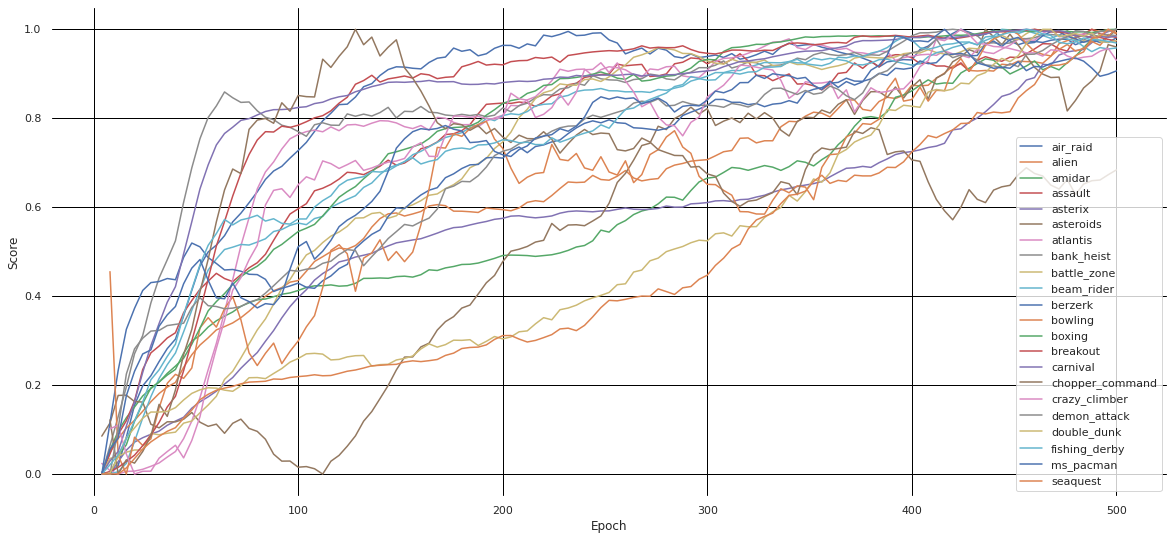

In [ ]:
!pip install pandas

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
from math import log, e
import matplotlib.pyplot as plt
import os

def pandas_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = 2 if base is None else base
  Hmax =  np.log(len(vc)) / np.log(base)
  # return -((vc * np.log(vc)/np.log(base))/Hmax).sum()
  return -(vc * np.log(vc)/np.log(base)).sum()

def normalize(x):
    return (x - x.min()) / (x.max() - x.min()) #x.ptp() -> peak to peak max-min

root =[ 'air_raid','alien','amidar','assault','asterix','asteroids','atlantis','bank_heist','battle_zone',
          'beam_rider','berzerk','bowling','boxing','breakout','carnival','chopper_command','crazy_climber',
          'demon_attack','double_dunk','fishing_derby','ms_pacman','seaquest']
# root =['double_dunk','fishing_derby']
score_norm = []
indexs = []
games = pd.DataFrame(columns=['Score','Frequency','Number','Mean', 'STD', 'Entropy', 'Delta', 'Epoch 90%'])
for game in root:
  reward_avg = pd.DataFrame(columns=['Epoch', 'Training','Score','Frequency','Mean', 'STD', 'Entropy', 'Number'])
  for ntrain in range(0,5):
    max = 0
    tot_action=pd.Series(); 
    gamen = game+"-"+str(ntrain)
    files = os.listdir(gamen) 
    for i in files: 
      e = int(i.split('-')[1]) / 25000
      epoch_stats = pd.DataFrame(columns=['Epoch','Score','Frequency' ,'Mean', 'STD', 'Entropy', 'Number'])
      dir = '{}/{}'.format(gamen, i)
      for n in range(1, 51): 
        # print("Training {} epoch {} game {}".format(ntrain, e, n));
        dist_tot= 0
        df = pd.read_csv('{}/reward_log_{}.txt'.format(dir, n), sep='\t')
        steps = df['STEP']
        for step in range(1, len(steps)):
          dist= steps[step] - steps[step-1]
          dist_tot = dist_tot + dist
        if (len(steps) > 1):
          dist_mean = dist_tot / len(steps)
        else :
          dist_mean = 0 
        # if e==4:
        #   print("epoch: {} ntrain:{} dist_mean: {}  dist_tot:{} len(steps):{}".format(e,ntrain,dist_mean,dist_tot,len(steps)))
        action= df['ACTION'].value_counts()
        tot_action = tot_action.add(action, fill_value=0)
        epoch_score = df['REWARD'].sum()
        epoch_mean = df['REWARD'].mean()
        epoch_entropy = pandas_entropy(df['REWARD'])
        epoch_n = df['REWARD'].count()
        if epoch_mean != 0:
          epoch_std = df['REWARD'].std() / epoch_mean 
        else:
          epoch_std = df['REWARD'].std() 
        epoch_stats.loc[len(epoch_stats)] = [e, epoch_score,dist_mean ,epoch_mean, epoch_std, epoch_entropy, epoch_n]
      

      a4_dims = (11.69, 8.27)
      score = epoch_stats['Score'].mean()
      frq = epoch_stats['Frequency'].mean()
      mean= epoch_stats['Mean'].mean()
      std= epoch_stats['STD'].mean()
      entropy = epoch_stats['Entropy'].mean()
      number = epoch_n.mean()   
      reward_avg.loc[len(reward_avg)] = [e, ntrain, score, frq, mean, std, entropy, number]

      del epoch_stats

  reward_avg=reward_avg.sort_values(by=['Epoch', 'Training'])
  # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
  #     print(reward_avg)

  reward_avg = reward_avg.groupby(['Epoch']).mean()
  reward_avg.sort_values(by=['Epoch'])
  indexs.append(reward_avg.index)

  # print(game)
  # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
  #    print(reward_avg)
        
  # print("{}: {}".format(game, tot_action))
    
  sns.set(rc={ 'grid.color':'black', 'axes.facecolor':'white', 'figure.figsize':(20,9)})
  y_score= pd.Series(reward_avg.Score)
  ma_score = y_score.rolling(window=10, min_periods=1).mean()
  y_norm = normalize(ma_score)
  score_norm.append(y_norm)
  c = 0
  for i in y_norm:
    if i > 0.9:
      e90 =  reward_avg.index[c]
      break
    c+=1 

  # plt.figure()
  # sns.lineplot(x=reward_avg.index, y=reward_avg.Score, err_style="band", ci=95)
  # sns.lineplot(x=ma_score.index, y=ma_score)
  # plt.ylim(0, None)
  # plt.savefig("score_{}.svg".format(game))
  # # sns.lineplot(x=reward_avg.index, y=y_norm, err_style="band", ci=95)

  # plt.figure()
  # sns.lineplot(x=reward_avg.index, y=reward_avg.Mean, err_style="band", ci=95)
  # plt.ylim(0, None)
  # plt.savefig("ra_{}.svg".format(game))

  # plt.figure()
  # sns.lineplot(x=reward_avg.index, y=reward_avg.STD, err_style="band", ci=95)
  # plt.ylim(0, None)
  # plt.savefig("rs_{}.svg".format(game))

  # plt.figure()
  # sns.lineplot(x=reward_avg.index, y=reward_avg.Entropy, err_style="band", ci=95)
  # plt.ylim(0, None)
  # plt.savefig("re_{}.svg".format(game))
  
  score = reward_avg['Score'].mean()
  frq = reward_avg['Frequency'].mean()
  mean= reward_avg['Mean'].mean()
  std= reward_avg['STD'].mean()
  entropy = reward_avg['Entropy'].mean()
  num = reward_avg['Number'].mean()
  delta= y_score.max() - y_score.min()
  games.loc[game] = [score, frq, num, mean, std, entropy, delta, e90]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(games)

plt.figure()
for i in range(len(root)):
  sns.lineplot(x=indexs[i], y=score_norm[i])
plt.legend(root)
plt.savefig("allscore.svg")

In [ ]:
# def pandas_entropy(column, base=None):
#   vc = pd.Series(column).value_counts(normalize=True, sort=False)
#   base = 2 if base is None else base
#   Hmax =  np.log(column.max()) / np.log(base)
#   return -((vc * np.log(vc)/np.log(base))/Hmax).sum()

root =[ 'air_raid','alien','amidar','assault','asterix','asteroids','atlantis','bank_heist','battle_zone',
          'beam_rider','berzerk','bowling','boxing','breakout','carnival','chopper_command','crazy_climber',
          'demon_attack','double_dunk','fishing_derby','ms_pacman','seaquest']
# root =['double_dunk','fishing_derby']
for game in root:
  MSE_avg = pd.DataFrame(columns=['Epoch', 'Training','Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  MSE_avg60 = pd.DataFrame(columns=['Epoch','Training','Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  MSE_avg120 = pd.DataFrame(columns=['Epoch','Training', 'Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  MSE_avg240 = pd.DataFrame(columns=['Epoch','Training', 'Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  MSE30 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  MSE60 = pd.DataFrame(columns=['Epoch','Mean', 'STD', 'Entropy'])
  MSE120 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  MSE240 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  for ntrain in range(0,5):
    gamen = game+"-"+str(ntrain)
    files = os.listdir(gamen) 
    for i in files: 
      epoch_stats = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats60 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats120 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats240 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch = pd.DataFrame()
      dir = '{}/{}'.format(gamen, i)
      try : 
        e = int(i.split('-')[1]) / 25000
      except:
        print("ERROR File: {}".format(i))
        print("Files: {}".format(files))
      for n in range(1, 51): 
        df = pd.read_csv('{}/image_log_{}.txt'.format(dir, n), delimiter = '\t')
        epoch = epoch.append(df)

        epoch_mean = df['MSE30'].mean()
        epoch_std = df['MSE30'].std() / epoch_mean 
        epoch_entropy = pandas_entropy(df['MSE30'])
        epoch_max_mean = df['MSE30'].max() / epoch_mean
        epoch_min_mean = df['MSE30'].min() / epoch_mean 
        MSE30.loc[len(MSE30)]= [e, epoch_mean, epoch_std, epoch_entropy]
        epoch_stats.loc[n-1] = [epoch_mean, epoch_std, epoch_entropy, epoch_min_mean, epoch_max_mean]

        epoch_mean60 = df['MSE60'].mean()
        epoch_std60 = df['MSE60'].std() / epoch_mean60 
        epoch_entropy60 = pandas_entropy(df['MSE60'])
        epoch_max_mean60 = df['MSE60'].max() / epoch_mean60
        epoch_min_mean60 = df['MSE60'].min() / epoch_mean60 
        MSE60.loc[len(MSE60)]= [e, epoch_mean60, epoch_std60, epoch_entropy60]
        epoch_stats60.loc[n-1] = [epoch_mean60, epoch_std60, epoch_entropy60, epoch_min_mean60, epoch_max_mean60]

        epoch_mean120 = df['MSE120'].mean()
        epoch_std120 = df['MSE120'].std() / epoch_mean120 
        epoch_entropy120 = pandas_entropy(df['MSE120'])
        epoch_max_mean120 = df['MSE120'].max() / epoch_mean120
        epoch_min_mean120 = df['MSE120'].min() / epoch_mean120 
        MSE120.loc[len(MSE120)]= [e, epoch_mean120, epoch_std120, epoch_entropy120]
        epoch_stats120.loc[n-1] = [epoch_mean120, epoch_std120, epoch_entropy120, epoch_min_mean120, epoch_max_mean120]

        epoch_mean240 = df['MSE240'].mean()
        epoch_std240 = df['MSE240'].std() / epoch_mean240 
        epoch_entropy240 = pandas_entropy(df['MSE240'])
        epoch_max_mean240 = df['MSE240'].max() / epoch_mean240
        epoch_min_mean240 = df['MSE240'].min() / epoch_mean240
        MSE240.loc[len(MSE240)]= [e, epoch_mean240, epoch_std240, epoch_entropy240]
        epoch_stats240.loc[n-1] = [epoch_mean240, epoch_std240, epoch_entropy240, epoch_min_mean240, epoch_max_mean240]

      mean= epoch_stats['Mean'].mean()
      std= epoch_stats['STD'].mean()
      entropy = epoch_stats['Entropy'].mean()
      max_mean = epoch_stats['Max/Mean'].mean() 
      min_mean = epoch_stats['Min/Mean'].mean()   
      MSE_avg.loc[len(MSE_avg)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats60['Mean'].mean()
      std= epoch_stats60['STD'].mean()
      entropy = epoch_stats60['Entropy'].mean()
      max_mean = epoch_stats60['Max/Mean'].mean() 
      min_mean = epoch_stats60['Min/Mean'].mean() 
      MSE_avg60.loc[len(MSE_avg60)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats120['Mean'].mean()
      std= epoch_stats120['STD'].mean()
      entropy = epoch_stats120['Entropy'].mean()
      max_mean = epoch_stats120['Max/Mean'].mean() 
      min_mean = epoch_stats120['Min/Mean'].mean() 
      MSE_avg120.loc[len(MSE_avg120)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats240['Mean'].mean()
      std= epoch_stats240['STD'].mean()
      entropy = epoch_stats240['Entropy'].mean()
      max_mean = epoch_stats240['Max/Mean'].mean() 
      min_mean = epoch_stats240['Min/Mean'].mean() 
      MSE_avg240.loc[len(MSE_avg240)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

  
  MSE_avg = MSE_avg.groupby(['Epoch']).mean()
  MSE_avg.sort_values(by=['Epoch'])
  MSE_avg60 = MSE_avg60.groupby(['Epoch']).mean()
  MSE_avg60.sort_values(by=['Epoch'])
  MSE_avg120 = MSE_avg120.groupby(['Epoch']).mean()
  MSE_avg120.sort_values(by=['Epoch'])
  MSE_avg240 = MSE_avg240.groupby(['Epoch']).mean()
  MSE_avg240.sort_values(by=['Epoch'])
 
  sns.set(rc={ 'grid.color':'black', 'axes.facecolor':'white', 'figure.figsize':(20,9)})

  # plt.figure()
  # sns.lineplot(x=MSE_avg.index, y=MSE_avg.Mean, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg60.index, y=MSE_avg60.Mean, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg120.index, y=MSE_avg120.Mean, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg240.index, y=MSE_avg240.Mean, err_style="band", ci=95)
  # plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  # plt.ylim(0, None)
  # plt.savefig("MSEm_{}.svg".format(game))

  # print("30: {} 60: {} 120: {} 240:{}".format(MSE_avg.Mean.mean(), MSE_avg60.Mean.mean(), MSE_avg120.Mean.mean(), MSE_avg240.Mean.mean()))

  # plt.figure()
  # sns.lineplot(x=MSE_avg.index, y=MSE_avg.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg60.index, y=MSE_avg60.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg120.index, y=MSE_avg120.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg240.index, y=MSE_avg240.STD, err_style="band", ci=95)
  # plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  # plt.ylim(0, None)
  # plt.savefig("MSEs_{}.svg".format(game))

  # print("30: {} 60: {} 120: {} 240:{}".format(MSE_avg.STD.mean(), MSE_avg60.STD.mean(), MSE_avg120.STD.mean(), MSE_avg240.STD.mean()))

  # plt.figure()
  # sns.lineplot(x=MSE_avg.index, y=MSE_avg.Entropy, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg60.index, y=MSE_avg60.Entropy, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg120.index, y=MSE_avg120.Entropy, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg240.index, y=MSE_avg240.Entropy, err_style="band", ci=95)
  # plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  # plt.ylim(0, None)
  # plt.savefig("MSEe_{}.svg".format(game))

  print(game + ':\n')
  print("30: {} 60: {} 120: {} 240:{}".format(MSE_avg.Entropy.mean(), MSE_avg60.Entropy.mean(), MSE_avg120.Entropy.mean(), MSE_avg240.Entropy.mean()))



air_raid:

30: 0.47780628537059294 60: 0.4312892535798738 120: 0.40190306502445355 240:0.34899838344103223
alien:

30: 0.6018376125550665 60: 0.48965426320302774 120: 0.3731671455612503 240:0.24224607841437862
amidar:

30: 0.6132365803529276 60: 0.5182447260095762 120: 0.3927916798420935 240:0.26214349217254546
assault:

30: 0.4922468144808809 60: 0.4557312720519085 120: 0.37872635240667474 240:0.28262175941851464
asterix:

30: 0.5629561817986443 60: 0.458512463234626 120: 0.35259465949113433 240:0.24066726359429394
asteroids:

30: 0.4167794969184825 60: 0.32616051463004536 120: 0.23566716041913596 240:0.13431791516649122
atlantis:

30: 0.5119204876362324 60: 0.46637750085757995 120: 0.4245339817605879 240:0.38799364634241496
bank_heist:

30: 0.3862008110520776 60: 0.3123595988910981 120: 0.2349872612270665 240:0.1516647016640334
battle_zone:

30: 0.48883884906374786 60: 0.43584140253305664 120: 0.3930864985126949 240:0.3180080861951341
beam_rider:

30: 0.4805145214964081 60: 0.4273009

30: 0.9550786494977638 60: 0.9514396838648285 120: 0.9495880654661991 240:0.9477062211912073
30: 0.02437879056600095 60: 0.023687832598190964 120: 0.022250478280049467 240:0.020537877875598312
30: 5.695289146529393 60: 5.068046930512259 120: 4.245709645869156 240:3.4826126982664762
30: 0.8590909098979059 60: 0.8593490817847774 120: 0.8554690787106278 240:0.8584607630787247
30: 0.021023316987224074 60: 0.019557129497538784 120: 0.02128328817837118 240:0.019873346600213313
30: 5.905673947057495 60: 4.8928138504359975 120: 3.8686737140821146 240:2.822275537964116


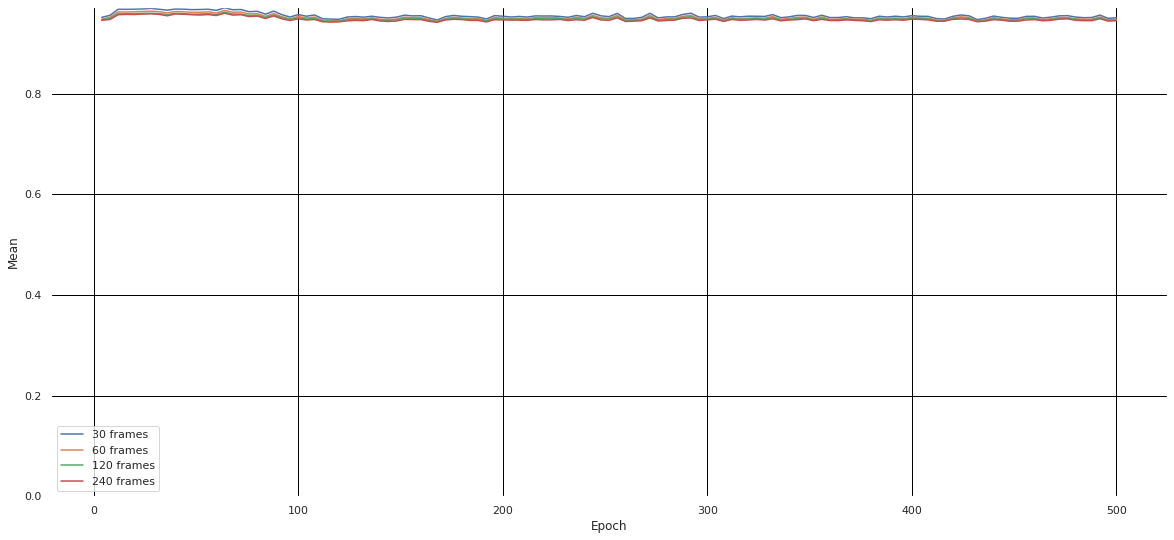

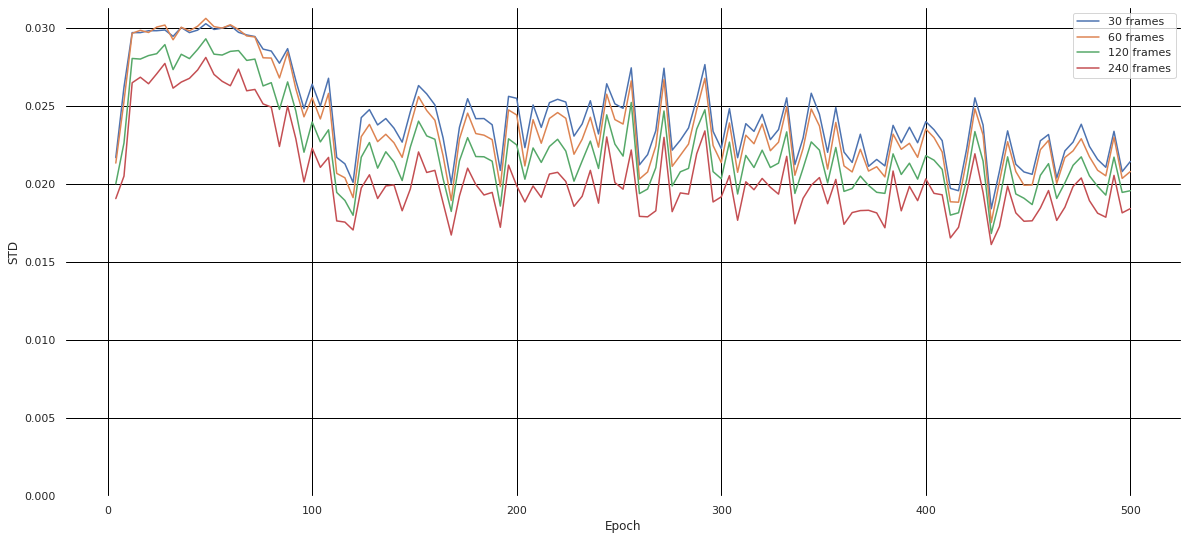

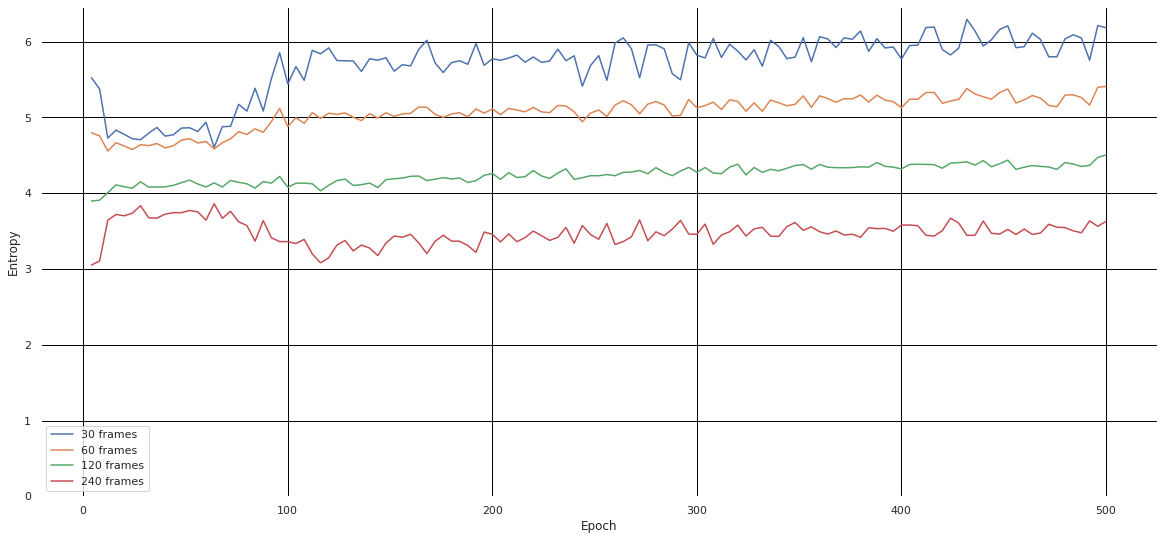

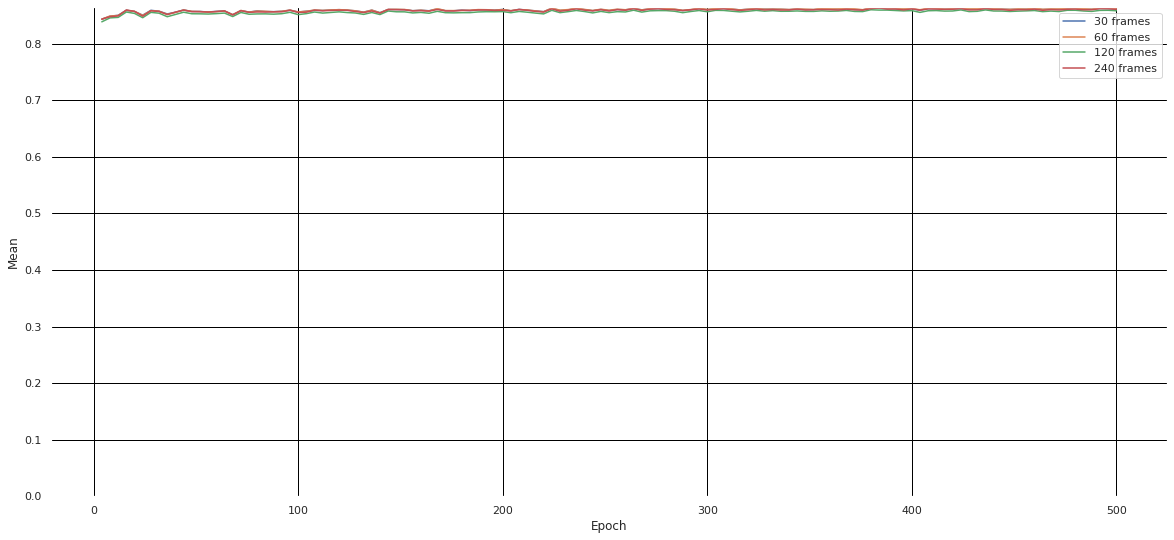

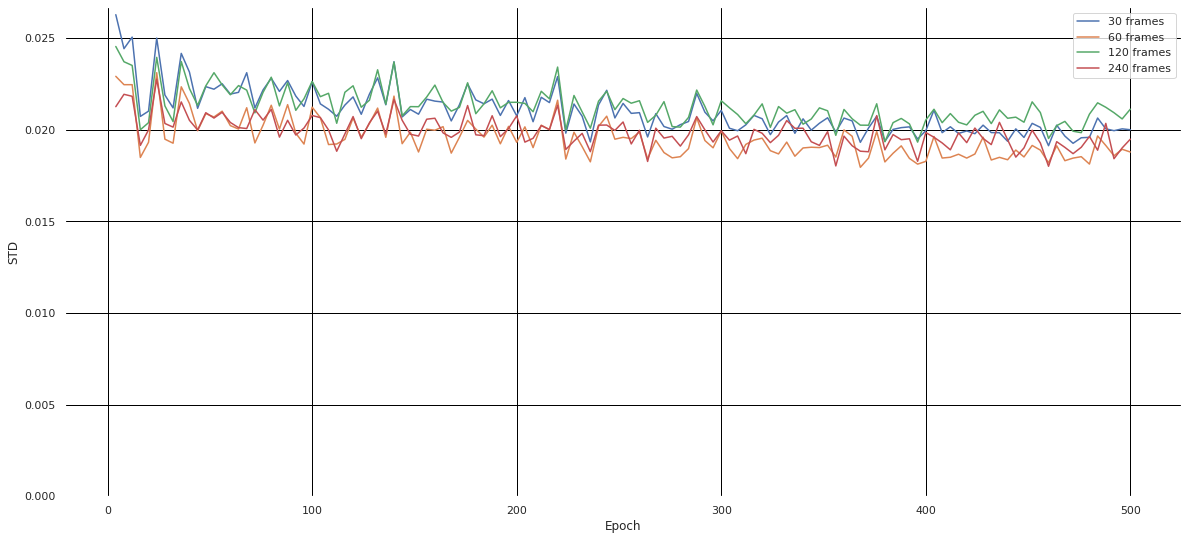

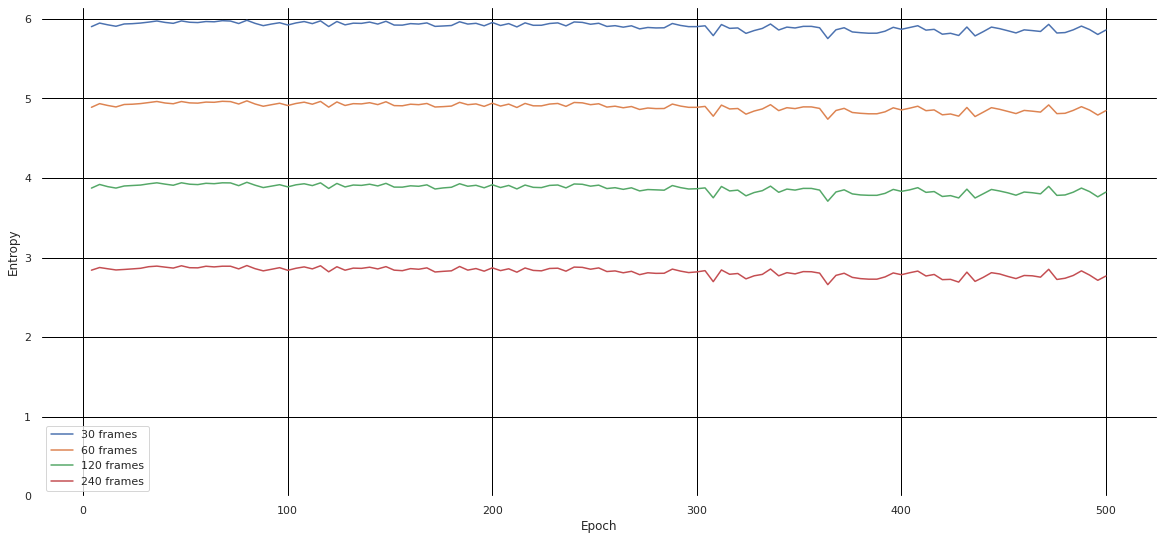

In [ ]:
def pandas_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = 2 if base is None else base
  Hmax =  np.log(len(vc)) / np.log(base)
  return -(vc * np.log(vc)/np.log(base)).sum()
  
# root =['air_raid','alien','amidar','assault','asterix','asteroids','beam_rider','breakout','ms_pacman','seaquest']
root =['double_dunk','fishing_derby']
for game in root:
  SSIM_avg = pd.DataFrame(columns=['Epoch', 'Training','Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  SSIM_avg60 = pd.DataFrame(columns=['Epoch','Training','Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  SSIM_avg120 = pd.DataFrame(columns=['Epoch','Training', 'Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  SSIM_avg240 = pd.DataFrame(columns=['Epoch','Training', 'Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  SSIM30 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  SSIM60 = pd.DataFrame(columns=['Epoch','Mean', 'STD', 'Entropy'])
  SSIM120 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  SSIM240 = pd.DataFrame(columns=['Epoch', 'Mean', 'STD', 'Entropy'])
  for ntrain in range(0,5):
    gamen = game+"-"+str(ntrain)
    files = os.listdir(gamen) 
    for i in files: 
      epoch_stats = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats60 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats120 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch_stats240 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch = pd.DataFrame()
      dir = '{}/{}'.format(gamen, i)
      try : 
        e = int(i.split('-')[1]) / 25000
      except:
        print("ERROR File: {}".format(i))
        print("Files: {}".format(files))
      for n in range(1, 51): 
        df = pd.read_csv('{}/image_log_{}.txt'.format(dir, n), delimiter = '\t')
        epoch = epoch.append(df)

        epoch_mean = df['SSIM30'].mean()
        epoch_std = df['SSIM30'].std() / epoch_mean 
        epoch_entropy = pandas_entropy(df['SSIM30'])
        epoch_max_mean = df['SSIM30'].max() / epoch_mean
        epoch_min_mean = df['SSIM30'].min() / epoch_mean 
        SSIM30.loc[len(SSIM30)]= [e, epoch_mean, epoch_std, epoch_entropy]
        epoch_stats.loc[n-1] = [epoch_mean, epoch_std, epoch_entropy, epoch_min_mean, epoch_max_mean]

        epoch_mean60 = df['SSIM60'].mean()
        epoch_std60 = df['SSIM60'].std() / epoch_mean60 
        epoch_entropy60 = pandas_entropy(df['SSIM60'])
        epoch_max_mean60 = df['SSIM60'].max() / epoch_mean60
        epoch_min_mean60 = df['SSIM60'].min() / epoch_mean60 
        SSIM60.loc[len(SSIM60)]= [e, epoch_mean60, epoch_std60, epoch_entropy60]
        epoch_stats60.loc[n-1] = [epoch_mean60, epoch_std60, epoch_entropy60, epoch_min_mean60, epoch_max_mean60]

        epoch_mean120 = df['SSIM120'].mean()
        epoch_std120 = df['SSIM120'].std() / epoch_mean120 
        epoch_entropy120 = pandas_entropy(df['SSIM120'])
        epoch_max_mean120 = df['SSIM120'].max() / epoch_mean120
        epoch_min_mean120 = df['SSIM120'].min() / epoch_mean120 
        SSIM120.loc[len(SSIM120)]= [e, epoch_mean120, epoch_std120, epoch_entropy120]
        epoch_stats120.loc[n-1] = [epoch_mean120, epoch_std120, epoch_entropy120, epoch_min_mean120, epoch_max_mean120]

        epoch_mean240 = df['SSIM240'].mean()
        epoch_std240 = df['SSIM240'].std() / epoch_mean240 
        epoch_entropy240 = pandas_entropy(df['SSIM240'])
        epoch_max_mean240 = df['SSIM240'].max() / epoch_mean240
        epoch_min_mean240 = df['SSIM240'].min() / epoch_mean240
        SSIM240.loc[len(SSIM240)]= [e, epoch_mean240, epoch_std240, epoch_entropy240]
        epoch_stats240.loc[n-1] = [epoch_mean240, epoch_std240, epoch_entropy240, epoch_min_mean240, epoch_max_mean240]

      mean= epoch_stats['Mean'].mean()
      std= epoch_stats['STD'].mean()
      entropy = epoch_stats['Entropy'].mean()
      max_mean = epoch_stats['Max/Mean'].mean() 
      min_mean = epoch_stats['Min/Mean'].mean()   
      SSIM_avg.loc[len(SSIM_avg)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats60['Mean'].mean()
      std= epoch_stats60['STD'].mean()
      entropy = epoch_stats60['Entropy'].mean()
      max_mean = epoch_stats60['Max/Mean'].mean() 
      min_mean = epoch_stats60['Min/Mean'].mean() 
      SSIM_avg60.loc[len(SSIM_avg60)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats120['Mean'].mean()
      std= epoch_stats120['STD'].mean()
      entropy = epoch_stats120['Entropy'].mean()
      max_mean = epoch_stats120['Max/Mean'].mean() 
      min_mean = epoch_stats120['Min/Mean'].mean() 
      SSIM_avg120.loc[len(SSIM_avg120)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

      mean= epoch_stats240['Mean'].mean()
      std= epoch_stats240['STD'].mean()
      entropy = epoch_stats240['Entropy'].mean()
      max_mean = epoch_stats240['Max/Mean'].mean() 
      min_mean = epoch_stats240['Min/Mean'].mean() 
      SSIM_avg240.loc[len(SSIM_avg240)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]

  
  SSIM_avg = SSIM_avg.groupby(['Epoch']).mean()
  SSIM_avg.sort_values(by=['Epoch'])
  SSIM_avg60 = SSIM_avg60.groupby(['Epoch']).mean()
  SSIM_avg60.sort_values(by=['Epoch'])
  SSIM_avg120 = SSIM_avg120.groupby(['Epoch']).mean()
  SSIM_avg120.sort_values(by=['Epoch'])
  SSIM_avg240 = SSIM_avg240.groupby(['Epoch']).mean()
  SSIM_avg240.sort_values(by=['Epoch'])
 
  sns.set(rc={ 'grid.color':'black', 'axes.facecolor':'white', 'figure.figsize':(20,9)})

  plt.figure()
  sns.lineplot(x=SSIM_avg.index, y=SSIM_avg.Mean, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg60.index, y=SSIM_avg60.Mean, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg120.index, y=SSIM_avg120.Mean, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg240.index, y=SSIM_avg240.Mean, err_style="band", ci=95)
  plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  plt.ylim(0, None)
  plt.savefig("SSIMm_{}.svg".format(game))

  print("30: {} 60: {} 120: {} 240:{}".format(SSIM_avg.Mean.mean(), SSIM_avg60.Mean.mean(), SSIM_avg120.Mean.mean(), SSIM_avg240.Mean.mean()))

  plt.figure()
  sns.lineplot(x=SSIM_avg.index, y=SSIM_avg.STD, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg60.index, y=SSIM_avg60.STD, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg120.index, y=SSIM_avg120.STD, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg240.index, y=SSIM_avg240.STD, err_style="band", ci=95)
  plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  plt.ylim(0, None)
  plt.savefig("SSIMs_{}.svg".format(game))

  print("30: {} 60: {} 120: {} 240:{}".format(SSIM_avg.STD.mean(), SSIM_avg60.STD.mean(), SSIM_avg120.STD.mean(), SSIM_avg240.STD.mean()))

  plt.figure()
  sns.lineplot(x=SSIM_avg.index, y=SSIM_avg.Entropy, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg60.index, y=SSIM_avg60.Entropy, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg120.index, y=SSIM_avg120.Entropy, err_style="band", ci=95)
  sns.lineplot(x=SSIM_avg240.index, y=SSIM_avg240.Entropy, err_style="band", ci=95)
  plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  plt.ylim(0, None)
  plt.savefig("SSIMe_{}.svg".format(game))

  print("30: {} 60: {} 120: {} 240:{}".format(SSIM_avg.Entropy.mean(), SSIM_avg60.Entropy.mean(), SSIM_avg120.Entropy.mean(), SSIM_avg240.Entropy.mean()))

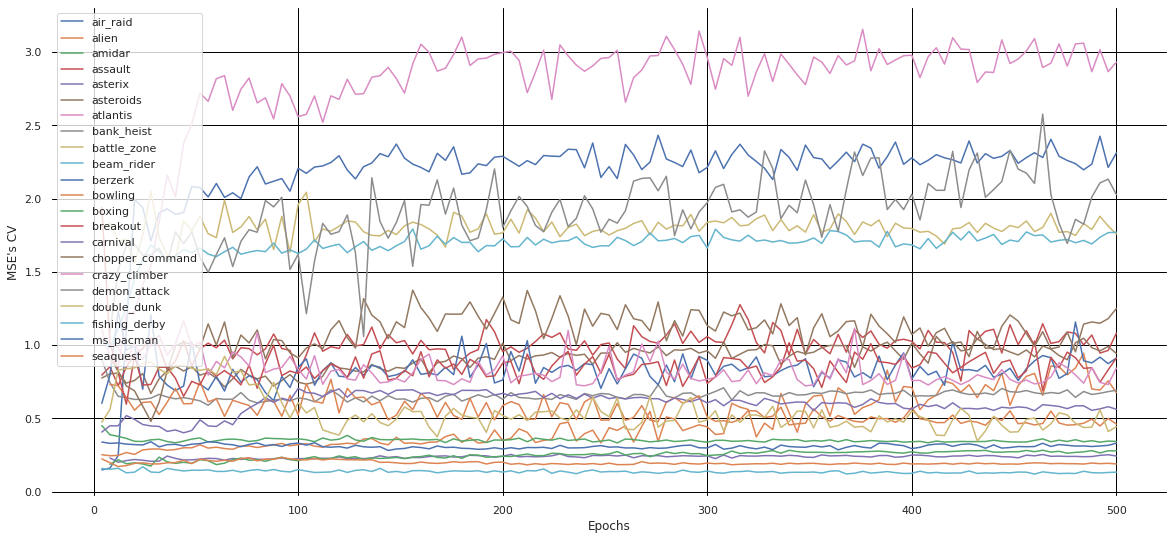

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
from math import log, e
import matplotlib.pyplot as plt
import os

def pandas_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = 2 if base is None else base
  Hmax =  np.log(column.max()) / np.log(base)
  return -((vc * np.log(vc)/np.log(base))/Hmax).sum()

root =[ 'air_raid','alien','amidar','assault','asterix','asteroids','atlantis','bank_heist','battle_zone',
          'beam_rider','berzerk','bowling','boxing','breakout','carnival','chopper_command','crazy_climber',
          'demon_attack','double_dunk','fishing_derby','ms_pacman','seaquest']
# root =['double_dunk','fishing_derby']
MSE = []
indexs = []
for game in root:
  MSE_avg60 = pd.DataFrame(columns=['Epoch','Training','Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
  MSE60 = pd.DataFrame(columns=['Epoch','Mean', 'STD', 'Entropy'])
  for ntrain in range(0,5):
    gamen = game+"-"+str(ntrain)
    files = os.listdir(gamen) 
    for i in files: 
      epoch_stats60 = pd.DataFrame(columns=['Mean', 'STD', 'Entropy', 'Min/Mean', 'Max/Mean'])
      epoch = pd.DataFrame()
      dir = '{}/{}'.format(gamen, i)
      try : 
        e = int(i.split('-')[1]) / 25000
      except:
        print("ERROR File: {}".format(i))
        print("Files: {}".format(files))
      for n in range(1, 51): 
        df = pd.read_csv('{}/image_log_{}.txt'.format(dir, n), delimiter = '\t')
        epoch = epoch.append(df)

        epoch_mean60 = df['MSE60'].mean()
        epoch_std60 = df['MSE60'].std() / epoch_mean60 
        epoch_entropy60 = pandas_entropy(df['MSE60'])
        epoch_max_mean60 = df['MSE60'].max() / epoch_mean60
        epoch_min_mean60 = df['MSE60'].min() / epoch_mean60 
        MSE60.loc[len(MSE60)]= [e, epoch_mean60, epoch_std60, epoch_entropy60]
        epoch_stats60.loc[n-1] = [epoch_mean60, epoch_std60, epoch_entropy60, epoch_min_mean60, epoch_max_mean60]

      mean= epoch_stats60['Mean'].mean()
      std= epoch_stats60['STD'].mean()
      entropy = epoch_stats60['Entropy'].mean()
      max_mean = epoch_stats60['Max/Mean'].mean() 
      min_mean = epoch_stats60['Min/Mean'].mean() 
      MSE_avg60.loc[len(MSE_avg60)] = [e, ntrain, mean, std, entropy, min_mean, max_mean]


  MSE_avg60 = MSE_avg60.groupby(['Epoch']).mean()
  MSE_avg60.sort_values(by=['Epoch'])
  MSE.append(pd.Series(MSE_avg60.STD))
  indexs.append(MSE_avg60.index)
 
sns.set(rc={ 'grid.color':'black', 'axes.facecolor':'white', 'figure.figsize':(20,9)})
plt.figure()
plt.ylabel("MSE's CV")
plt.xlabel("Epochs")
for i in range(len(root)):
  sns.lineplot(x=indexs[i], y=MSE[i])
plt.legend(root)
plt.savefig("allMSE.jpg")

  # plt.figure()
  # sns.lineplot(x=MSE_avg.index, y=MSE_avg.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg60.index, y=MSE_avg60.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg120.index, y=MSE_avg120.STD, err_style="band", ci=95)
  # sns.lineplot(x=MSE_avg240.index, y=MSE_avg240.STD, err_style="band", ci=95)
  # plt.legend(["30 frames", "60 frames", "120 frames", "240 frames"])
  # plt.ylim(0, None)
  # plt.savefig("MSEs_{}.svg".format(game))




ACTIONS COUNT

In [ ]:
import pandas as pd 
actions=  pd.read_csv('boxing_action.txt')

tot_actions = []

tot_actions.append(actions["action_0"].sum())
tot_actions.append(actions["action_1"].sum())
tot_actions.append(actions["action_2"].sum())
tot_actions.append(actions["action_3"].sum())
tot_actions.append(actions["action_4"].sum())
tot_actions.append(actions["action_5"].sum())
tot_actions.append(actions["action_6"].sum())
tot_actions.append(actions["action_7"].sum())
tot_actions.append(actions["action_8"].sum())
tot_actions.append(actions["action_9"].sum())
tot_actions.append(actions["action_10"].sum())
tot_actions.append(actions["action_11"].sum())
tot_actions.append(actions["action_12"].sum())
tot_actions.append(actions["action_13"].sum())
tot_actions.append(actions["action_14"].sum())
tot_actions.append(actions["action_15"].sum())
tot_actions.append(actions["action_16"].sum())
tot_actions.append(actions["action_17"].sum())

print(tot_actions)


[682246, 1120402, 1368855, 1081244, 1004173, 1347261, 1604563, 1242677, 1511709, 1008164, 1910342, 1326146, 860088, 1802960, 2088519, 1372468, 2103337, 1459581]


SCATTER

In [ ]:
import pandas as pd 
import seaborn as sns

s10 = pd.read_csv('scatter10.csv')
s100 = pd.read_csv('scatter100.csv')
s500 = pd.read_csv('scatter500.csv')

sns.set(rc={ 'grid.color':'black','figure.figsize':(20,9)})
g = sns.PairGrid(s10)
g.map(sns.scatterplot)
g.savefig("scatter10.svg")

In [ ]:
sns.set(rc={ 'grid.color':'black','figure.figsize':(20,9)})
g = sns.PairGrid(s100)
g.map(sns.scatterplot)
g.savefig("scatter100.svg")

In [ ]:
sns.set(rc={ 'grid.color':'black','figure.figsize':(20,9)})
g = sns.PairGrid(s500)
g.map(sns.scatterplot)
g.savefig("scatter500.svg")

CORRELATION


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

   
df = pd.read_csv('norm.tsv', delimiter = '\t')
lr=pd.Series(df['LR']) 
pearson = []
spearman = []
for feature in df.columns:
  if feature!="LR":
    data=pd.Series(df[feature])
    p, _ = stats.pearsonr(lr, data)
    s, _ = stats.spearmanr(lr, data)
    print("Features {}".format(feature))
    x = df[feature].to_numpy()
    y = df['LR'].to_numpy()
    x = x.reshape((-1, 1))
    model = LinearRegression()
    model.fit(x,y)
    r_sq = model.score(x, y)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)
    print('pearson: ',p)
    print('spearman: ',s)
    # print("{} {}  {}".format(feature,p,s))

    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    pearson.append("{} : {}".format(feature, p))
    spearman.append("{} : {}".format(feature, s))

    # prstd, iv_l, iv_u = wls_prediction_std(est2)

    # fig, ax = plt.subplots(figsize=(20,9))

    # ax.plot(x, y, 'o', label=feature)
    # #ax.plot(x, y_true, 'b-', label="True")
    # ax.plot(x, est2.fittedvalues, 'r--.', label="Predicted")
    # # ax.plot(x, iv_u, 'r--')
    # # ax.plot(x, iv_l, 'r--')
    # legend = ax.legend(loc="best")

# used = ["LR"]
# for i in df.columns:
#   for j in df.columns:
#     if i != j and i not in used and j not in used:
#       print("Features {} {}".format(i,j))
#       x = df[[i, j]].to_numpy()
#       y = df['LR'].to_numpy()
#       model = LinearRegression()
#       model.fit(x,y)
#       r_sq = model.score(x, y)
#       print('coefficient of determination:', r_sq)
#       print('intercept:', model.intercept_)
#       print('slope:', model.coef_)

#       X2 = sm.add_constant(x)
#       est = sm.OLS(y, X2)
#       est2 = est.fit()
#       print(est2.summary())
#   used.append(i)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Features # actions
coefficient of determination: 0.044243468466571116
intercept: 270.50625812187945
slope: [3.94200123]
pearson:  0.21034131421708643
spearman:  0.2772346764602244
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9258
Date:                Tue, 30 Mar 2021   Prob (F-statistic):              0.347
Time:                        15:11:36   Log-Likelihood:                -132.68
No. Observations:                  22   AIC:                             269.4
Df Residuals:                      20   BIC:                             271.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std e

coefficient of determination: 0.21718137038118224
intercept: 0.7476268189523837
slope: [-0.5391369]
pearson:  -0.4660272206440118
spearman:  -0.5757063065700074
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     5.549
Date:                Tue, 16 Mar 2021   Prob (F-statistic):             0.0288
Time:                        15:31:24   Log-Likelihood:                -2.5731
No. Observations:                  22   AIC:                             9.146
Df Residuals:                      20   BIC:                             11.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

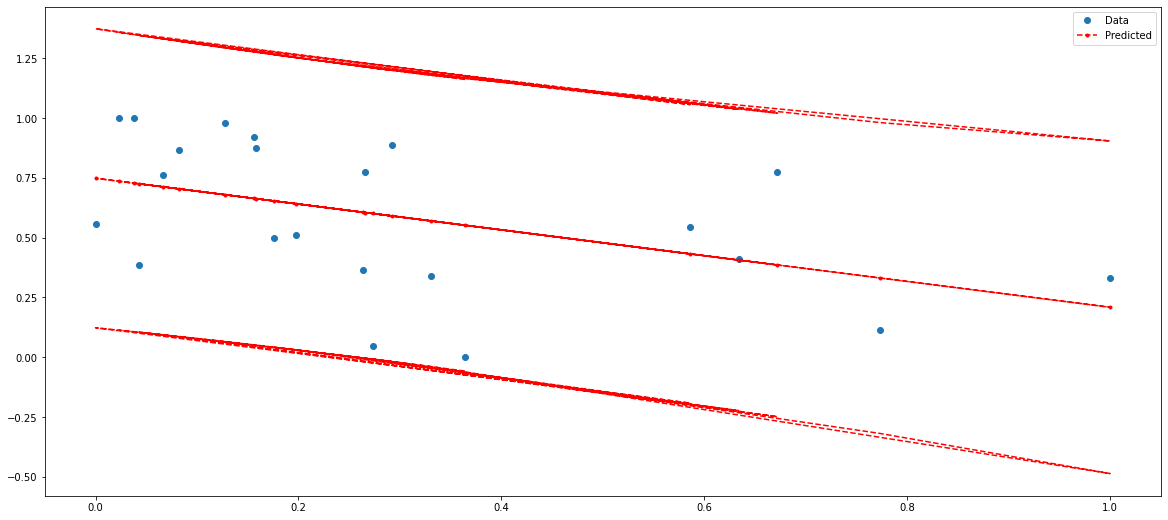

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

   
df = pd.read_csv('norm.tsv', delimiter = '\t')
lr=pd.Series(df['LR']) 
feature = 'MSE_CoV'
data=pd.Series(df[feature])
p, _ = stats.pearsonr(lr, data)
s, _ = stats.spearmanr(lr, data)

x = df[feature].to_numpy()
y = df['LR'].to_numpy()
# Test if orders metters, order both array for the feature and not ToL
# perm = x.argsort()
# x = x[perm]
# y = y[perm]
# print("X ordered {}".format(x))
# print("Y {}".format(y))
x = x.reshape((-1, 1))
model = LinearRegression()
model.fit(x,y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
print('pearson: ',p)
print('spearman: ',s)

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

prstd, iv_l, iv_u = wls_prediction_std(est2)

fig, ax = plt.subplots(figsize=(20,9))

ax.plot(x, y, 'o', label="Data")
#ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, est2.fittedvalues, 'r--.', label="Predicted")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
legend = ax.legend(loc="best")